In [1]:
# import dependencies
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import interpolate, stats
import pandas as pd
import utils.readin_utils as readin

# matplotlib config
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 100} #plotting pretty

In [2]:
# Settings for Analysis

# settings for exlusion
minimum_dim = 500

# settings for contour plots
c_cmap = 'brg' # colormap for contour plots
c_levels = np.array([0.9, 0.8, 0.6, 0.3, 0.1]) # energy percentages to contour
interp_val = 5

# settings for calcuations
alpha_a_fitrange = [0.02, 0.35] 

number of aca images: 136
min aca image height: 504
min aca image width: 640
number of naca images: 72
min naca image height: 601
min naca image width: 719


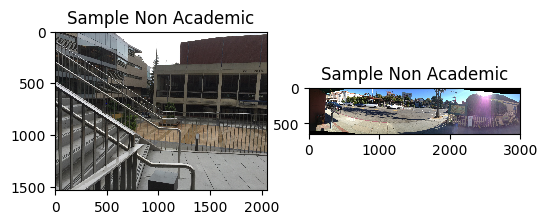

In [3]:
# Read our photo files
aca_datadir = './data/**/*Pano*/*AP*/**'
naca_datadir = './data/**/*Pano*/*NA*/**'
both_datadir = './data/**/'

aca_image_files = readin.readin_jpgs(aca_datadir)
naca_image_files = readin.readin_jpgs(naca_datadir)
image_files = readin.readin_jpgs(both_datadir)#aca_image_files + naca_image_files

try:
    raw_images
except NameError:
    raw_images, raw_flist, min_h, min_w = readin.read_ims(image_files, minimum_dim)
    aca_raw_images, aca_raw_flist, aca_min_h, aca_min_w = readin.read_ims(aca_image_files, minimum_dim)
    naca_raw_images, naca_raw_flist, naca_min_h, naca_min_w = readin.read_ims(naca_image_files, minimum_dim)
    #use less of height and width to make samples square
    min_dim = min(aca_min_h, aca_min_w, naca_min_h, naca_min_w)
    
plt.subplot(1, 2, 1, title="Sample Academic")
plt.imshow(aca_raw_images[0])


print('number of aca images: {}'.format(np.shape(aca_raw_images)[0]))
print('min aca image height: {}'.format(aca_min_h))
print('min aca image width: {}'.format(aca_min_w))

plt.subplot(1, 2, 2, title="Sample Non Academic")
plt.imshow(naca_raw_images[0])

print('number of naca images: {}'.format(np.shape(naca_raw_images)[0]))
print('min naca image height: {}'.format(naca_min_h))
print('min naca image width: {}'.format(naca_min_w))


In [4]:
# read in axial lengths
aca_xls = './data/Non Academic Period Master Spreadsheet 8.13.15 .xlsx'
nonaca_xls = './data/Academic Period Master Spreadsheet 8.13.15 .xlsx'

aca_als = readin.readin_al_xls(aca_xls)
aca_als.columns = ['ACA OD AL','ACA OS AL']
naca_als = readin.readin_al_xls(nonaca_xls)
naca_als.columns = ['NACA OD AL','NACA OS AL']

# combine to one spreadsheet
als = pd.concat([aca_als,naca_als],axis=1)
subjects = als.index

# Print table
#als 

In [42]:
def cropims(ims, crop_h, crop_w, area):
    h_crop_h = np.int(crop_h/2)
    h_crop_w = np.int(crop_w/2)
    # newims = np.ones((np.shape(ims)[0],crop_h,crop_w,3))
    newims = []
    for i, im in enumerate(ims):
        # print(np.shape(im))
        im_h = np.shape(im)[0]
        im_w = np.shape(im)[1]
        h_im_h = np.int(im_h / 2) # half image height
        h_im_w = np.int(im_w / 2) # half image width
        if(area=='middle'):
            newim = im[h_im_h - h_crop_h:h_im_h + h_crop_h, # crop height
                       h_im_w - h_crop_w:h_im_w + h_crop_w, # crop width
                       :]
        elif(area=='top'):
            newim = im[0:crop_h, # crop height
                       h_im_w - h_crop_w:h_im_w + h_crop_w, # crop width
                       :]
        elif(area=='bottom'):
            newim = im[im_h - crop_h:im_h, # crop height
                       h_im_w - h_crop_w:h_im_w + h_crop_w, # crop width
                       :]
        else:
            raise ValueError('area not well specified!')
        # print(np.shape(newim))
        # newims[i,:,:,:] = newim
        newims.append(newim)
    return(newims)

def avgims(ims):
    ims_arr = np.asarray(ims)
    # average images  - first index must be list of images
    avg = np.zeros_like(ims_arr[0])
    # print(np.shape(avg))
    for c in range(np.shape(avg)[2]): # loop over R, G, and B
        avg[:, :, c] = np.mean(ims_arr[:, :, :, c], axis=0)
    return(avg)

def spatialft(image):
    """Take the fourier transform of the image.
    shift the quadrants around so that low spatial frequencies are in
    the center of the 2D fourier transformed image"""
    
    greyavgim = np.mean(np.asarray(image),axis=2)  # average over colors
    greyavgim =  greyavgim - np.mean(greyavgim)  # remove DC component
    ft = np.abs(np.fft.fftshift(np.fft.fft2(greyavgim)))
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[1]))]
    ps = ft**2
    return(greyavgim, ft, ps, fqs)

def get_logspace_contours(raw_field, c_levels=c_levels):
    """Get the contour locations by percentage"""
    log_field = np.log10(raw_field)
    field = log_field / log_field.sum()
    n = 1000
    t = np.linspace(0, field.max(), n)
    integral = ((field >= t[:, None, None]) * field).sum(axis=(1, 2))
    f = interpolate.interp1d(integral, t)
    
    t_contours = f(c_levels) * log_field.sum()
    linear_t_contours = 10**t_contours
    
    return(linear_t_contours)

def fit_alpha_as(set_ims, dir):
    
    set_avgim = avgims(set_ims)
    
    # 1/f function to fit
    def feq(cpd, a, alpha):
        amp = a / (cpd**alpha)
        return(amp)
    
    # data to fit function to
    minfit = alpha_a_fitrange[0]
    maxfit = alpha_a_fitrange[1]
    
    # initialize values
    xs_vert = []
    ys_vert = []
    xs_horz = []
    ys_horz = []
    xs_skew = []
    ys_skew = []
    
    # cacluate ft and fit values for each image, so we have many points to fit
    for i, im in enumerate(set_ims):
        # normalize our image
        normim = im / np.max(set_avgim)
        
        # calculate the fourier transform
        im_bw, ft2d, ps2d, fqs = spatialft(normim)
        
        # vertical
        
        # which VERTICAL frequency is closest to the min we want (index)?
        minfq_v = np.abs(fqs[1] - minfit).argmin()
        # which VERTICAL frequency is closest to the max we want (index)?
        maxfq_v = np.abs(fqs[1] - maxfit).argmin()
        # add our values for VERTICAL frequencies between these limits
        xs_vert.append(fqs[1][minfq_v:maxfq_v])
        # add our values for VERTICAL fourier amps in this limit
        ys_vert.append(ft2d[int(np.shape(ft2d)[0]/2),minfq_v:maxfq_v])
        
        
        # horizontal
        # index of horiz frequency closest to range
        minfq_h = np.abs(fqs[0] - minfit).argmin()
        # index of horiz frequency closest to range
        maxfq_h = np.abs(fqs[0] - maxfit).argmin()
        # horiz fqs in these limits
        xs_horz.append(fqs[0][minfq_h:maxfq_h])
        # hoirz fourier amps in range
        ys_horz.append(ft2d[minfq_h:maxfq_h, int(np.shape(ft2d)[1] / 2)])
        
        # skew 
        # use x index here [0] to ensure same size
        skewfqs = np.sqrt(np.add(fqs[0][-int(np.shape(ft2d)[0]/2):]**2,
                                 fqs[1][-int(np.shape(ft2d)[0]/2):]**2))

        # skew frequncies diagonally out from middle by pythagorean therom ASSUME EQUALLY SPACED
        # index of skew fq closest to range
        minfq_s = np.abs(skewfqs - minfit).argmin()
        # index of skew fq closest to range
        maxfq_s = np.abs(skewfqs - maxfit).argmin()
        
        xs_skew.append(skewfqs[minfq_s:maxfq_s])
        
        # start from middle to measure fqs
        ys_skew.append(np.diagonal(ft2d[int(np.shape(ft2d)[0]/2) + minfq_s:int(np.shape(ft2d)[0]/2) + maxfq_s,
                                   int(np.shape(ft2d)[1]/2) + minfq_s:int(np.shape(ft2d)[1]/2) + maxfq_s]))
        
    # vertical
    [a_vert, alpha_vert], vert_cov = scipy.optimize.curve_fit(feq,
                                                              np.array(xs_vert).flatten(),
                                                              np.array(ys_vert).flatten())
    # convert to 1 SD
    [a_vert_se, alpha_vert_se] = np.sqrt(np.diag(vert_cov))

    # horizontal
    [a_horz, alpha_horz], horz_cov = scipy.optimize.curve_fit(feq,
                                                              np.array(xs_horz).flatten(),
                                                              np.array(ys_horz).flatten())
    # convert to 1 SD
    [a_horz_se, alpha_horz_se] = np.sqrt(np.diag(horz_cov))

    # skew
    [a_skew, alpha_skew], skew_cov = scipy.optimize.curve_fit(feq,
                                                              np.array(xs_skew).flatten(),
                                                              np.array(ys_skew).flatten())
    [a_skew_se, alpha_skew_se] = np.sqrt(np.diag(skew_cov))

    
    a_vhs_exp = [a_vert, a_horz, a_skew]
    a_vhs_se = [a_vert_se, a_horz_se, a_skew_se]
    alpha_vhs_exp = [alpha_vert, alpha_horz, alpha_skew]
    alpha_vhs_se = [alpha_vert_se, alpha_horz_se, alpha_skew_se]

    return(a_vhs_exp, a_vhs_se, alpha_vhs_exp, alpha_vhs_se)


def interp_get_contours(ps):
    interp = scipy.ndimage.filters.gaussian_filter(ps, interp_val)
    contours = get_logspace_contours(interp)
    return(interp, contours)

def contour_plotter(ps, fqs, bar=True, ticks=True):
    """Function to make contour plots"""
    interp, contours = interp_get_contours(ps)
    cont_pl = plt.pcolormesh(fqs[1],
                             fqs[0],
                             interp,
                             cmap="gray",
                             norm=mpl.colors.LogNorm())#,extent=extents)
    
    if(bar):
        cont_pl = plt.colorbar()
        
    if not(ticks):
        plt.axis('off')
    
    pl = plt.contour(fqs[1],
                     fqs[0],
                     interp,
                     levels=contours,
                     cmap=c_cmap,
                     norm=mpl.colors.LogNorm())
    return(pl)


def implot(im):
    pl = plt.imshow(im)
    pl = plt.axis('off')

def analyze_imset(set_ims,min_dim,dictloc):
    
    for loc in ['top', 'middle', 'bottom']:
        dictloc[loc] = {}

        # calculate cropped version of images
        cropped = cropims(ims=set_ims,
                          crop_h=min_dim,
                          crop_w=min_dim,
                          area=loc)
        dictloc[loc]['images'] = cropped

        # calculate average image
        dictloc[loc]['avgim'] = avgims(dictloc[loc]['images'])
        # calcuate FT & PS
        fft_results = spatialft(dictloc[loc]['avgim'])
        dictloc[loc]['avgim_bw'] = fft_results[0]
        dictloc[loc]['avgim_fft'] = fft_results[1]
        dictloc[loc]['avgim_ps'] = fft_results[2]
        dictloc[loc]['avgim_fft_freqs'] = fft_results[3]
        #fit alpha
        alpha_fits = fit_alpha_as(dictloc[loc]['images'])
        dictloc[loc]['avgim_a'] = alpha_fits[0]
        dictloc[loc]['avgim_a_dev'] = alpha_fits[1]
        dictloc[loc]['avgim_alpha'] = alpha_fits[2]
        dictloc[loc]['avgim_alpha_dev'] = alpha_fits[3]

    return(dictloc)

In [6]:
# make a dictionary to organize our data better
ddict = {}

# summarize academic and non academic for ALL subjects
ddict['ACA'] = {}
ddict['NACA'] = {}
# add raw images to our dictionary
ddict['ACA']['images_raw'] = aca_raw_images
ddict['NACA']['images_raw'] = naca_raw_images
# analyze overall NACA and ACA
ddict['ACA'] = analyze_imset(set_ims = aca_raw_images,
                             min_dim = min_dim,
                             dictloc = ddict['ACA'])
ddict['NACA'] = analyze_imset(set_ims = naca_raw_images,
                              min_dim = min_dim,
                              dictloc = ddict['NACA'])

# analyze images for each individual subject
for i, sub in enumerate(subjects):
    
    # get lists of subject's images - must leave as list because they are different sizes
    aca_sub_idxs = [i for i, x in enumerate(aca_raw_flist) if sub in x]
    naca_sub_idxs = [i for i, x in enumerate(naca_raw_flist) if sub in x]
    aca_subims = [aca_raw_images[i] for i in aca_sub_idxs]
    naca_subims = [naca_raw_images[i] for i in naca_sub_idxs]
    sub_idxs = [i for i, x in enumerate(raw_flist) if sub in x]
    subims = [raw_images[i] for i in sub_idxs]
    
    # make a sub dictionary 
    ddict[sub] = {}
      
    # put AL values into dict
    ddict[sub]['AL'] = als.loc[sub]
    
    # analyze subject's overall images
    thisloc = ddict[sub]

    # if there are images in this category then calculate averages and ft for them
    if not np.shape(subims) == (0, ):
        ddict[sub] = analyze_imset(set_ims = subims,
                                min_dim = min_dim,
                                dictloc = thisloc)

    # analyze academic & nonacademic separately
    if not np.shape(aca_subims) == (0, ):
        school = 'ACA'
        ddict[sub][school] = {}
        ddict[sub][school]['images_raw'] = aca_subims
        #variable containing our position in dictionary
        thisloc = ddict[sub][school]
        #if there are images in this category then calculate averages and ft for them
        ddict[sub][school] = analyze_imset(set_ims = thisloc['images_raw'],
                                        min_dim = min_dim,
                                        dictloc = thisloc)
    if not np.shape(naca_subims) == (0, ):
        school = 'NACA'
        ddict[sub][school] = {}
        ddict[sub][school]['images_raw'] = naca_subims
        #variable containing our position in dictionary
        thisloc = ddict[sub][school]
        #if there are images in this category then calculate averages and ft for them
        ddict[sub][school] = analyze_imset(set_ims = thisloc['images_raw'],
                                        min_dim = min_dim,
                                        dictloc = thisloc)
  
           

In [12]:
print(ddict.keys())

dict_keys(['ACA', 'NACA', 'AG102816', 'AH110515', 'AL100115', 'AN120915', 'CB030217', 'CH121015', 'CL021617', 'CM021816', 'DC080615', 'DG110915', 'DH030317', 'GG073115', 'GJ041316', 'HL110215', 'HM110316', 'IK030117', 'JC101615', 'JC102715', 'JC110615', 'JF041316', 'JH091715', 'JL031017', 'JN110915', 'LS073115', 'LW072415', 'MC110416', 'MD072415', 'MH020416', 'ML033116', 'ML072115', 'MN120815', 'MR021617', 'NS091015', 'PS102015', 'SB101416', 'SG021116', 'SZ091115', 'TE072715', 'TK0201416', 'VP041416', 'WO021616'])


dict_keys(['images', 'avgim', 'avgim_bw', 'avgim_fft', 'avgim_ps', 'avgim_fft_freqs', 'avgim_a', 'avgim_a_dev', 'avgim_alpha', 'avgim_alpha_dev'])


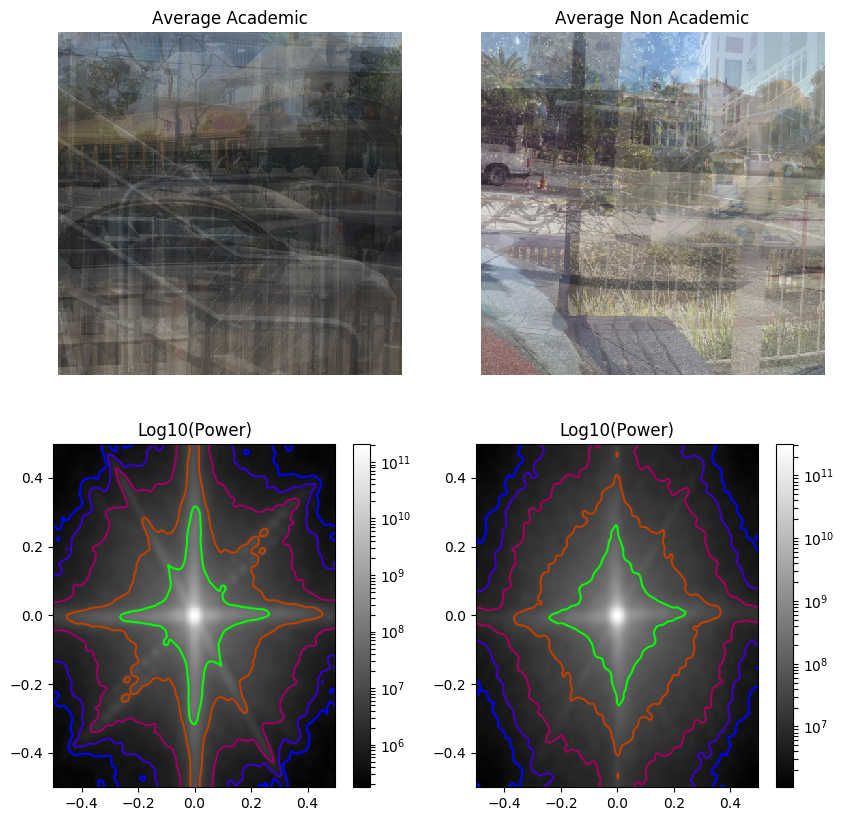

In [51]:
#plot a few example images

sample_sub = 'AH110515'
sample_loc = 'middle'

print(ddict[sample_sub]['ACA'][sample_loc].keys())

plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1, title="Average Academic")
implot(ddict[sample_sub]['ACA'][sample_loc]['avgim'])


plt.subplot(2, 2, 2, title="Average Non Academic")
implot(ddict[sample_sub]['NACA'][sample_loc]['avgim'])

plt.subplot(2, 2, 3, title='Log10(Power)')
contour_plotter(ps = ddict[sample_sub]['ACA'][sample_loc]['avgim_ps'],
                fqs = ddict[sample_sub]['ACA'][sample_loc]['avgim_fft_freqs'],
                bar=True)

plt.subplot(2, 2, 4, title='Log10(Power)')
contour_plotter(ps = ddict[sample_sub]['NACA'][sample_loc]['avgim_ps'],
                fqs = ddict[sample_sub]['NACA'][sample_loc]['avgim_fft_freqs'],
                bar=True)

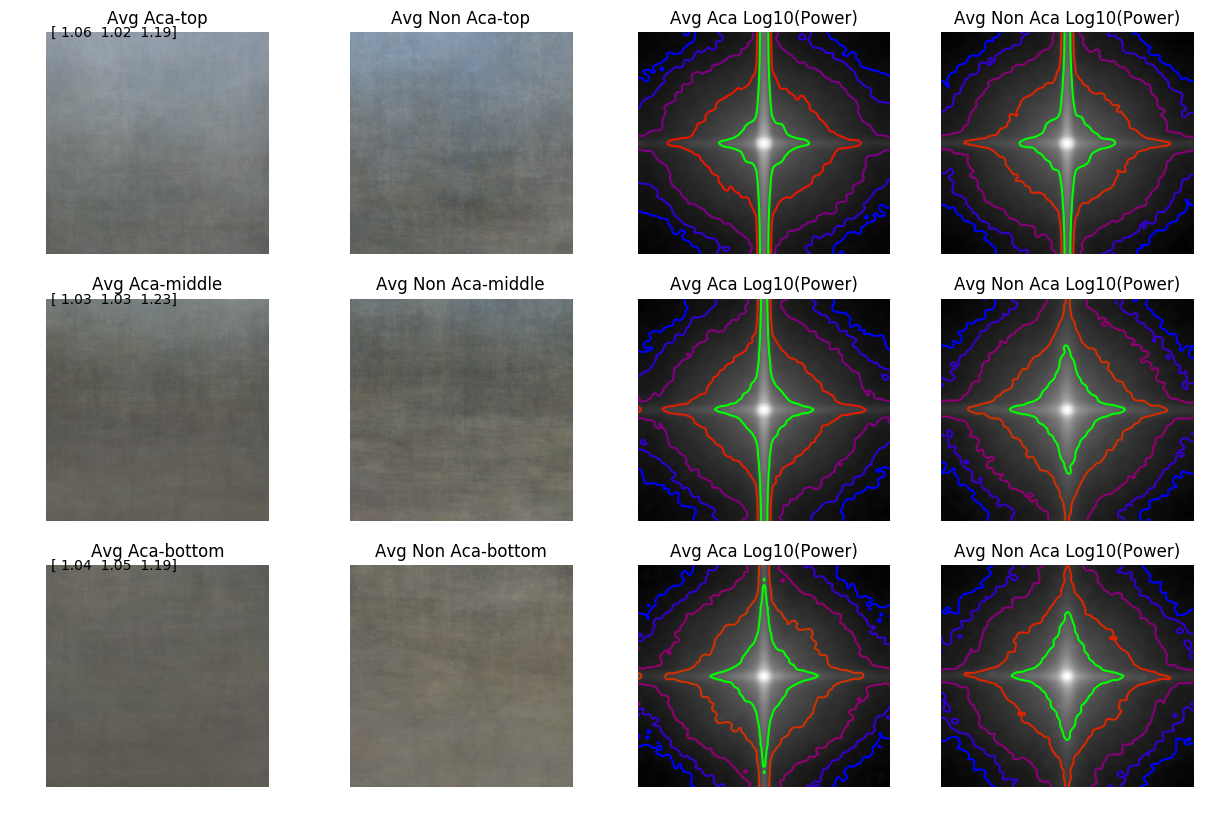

In [55]:
#plot a few example images

plt.figure(figsize=(15,10))

for i, sample_loc in enumerate(['top','middle','bottom']):

    ax = plt.subplot(3, 4, 1+(4*i), title="Avg Aca-{}".format(sample_loc))
    implot(ddict['ACA'][sample_loc]['avgim'])
    ax.annotate(np.round(ddict['ACA'][sample_loc]['avgim_alpha'],2),xy=(10,10))

    ax = plt.subplot(3, 4, 2+(4*i), title="Avg Non Aca-{}".format(sample_loc))
    implot(ddict['NACA'][sample_loc]['avgim'])

    ax = plt.subplot(3, 4, 3+(4*i), title='Avg Aca Log10(Power)')
    contour_plotter(ps = ddict['ACA'][sample_loc]['avgim_ps'],
                    fqs = ddict['ACA'][sample_loc]['avgim_fft_freqs'], bar=False, ticks=False)

    ax = plt.subplot(3, 4, 4+(4*i), title='Avg Non Aca Log10(Power)')
    contour_plotter(ps = ddict['NACA'][sample_loc]['avgim_ps'],
                    fqs = ddict['NACA'][sample_loc]['avgim_fft_freqs'], bar=False, ticks=False)

In [ ]:
## summary plots

aca_top_a, aca_top_a_dev, aca_top_alpha, aca_top_alpha_dev = fit_alpha_as(aca_images_top)
aca_middle_a, aca_middle_a_dev,aca_middle_alpha, aca_middle_alpha_dev = fit_alpha_as(aca_images_middle)
aca_bottom_a, aca_bottom_a_dev,aca_bottom_alpha, aca_bottom_alpha_dev = fit_alpha_as(aca_images_bottom)

naca_top_a, naca_top_a_dev, naca_top_alpha, naca_top_alpha_dev = fit_alpha_as(naca_images_top)
naca_middle_a, naca_middle_a_dev,naca_middle_alpha, naca_middle_alpha_dev = fit_alpha_as(naca_images_middle)
naca_bottom_a, naca_bottom_a_dev,naca_bottom_alpha, naca_bottom_alpha_dev = fit_alpha_as(naca_images_bottom)

a_alpha_fits = pd.DataFrame([['a', 'vertical', 'top', aca_top_a[0], naca_top_a[0]],
                             ['a', 'vertical', 'middle',aca_middle_a[0],naca_middle_a[0]],
                             ['a', 'vertical', 'bottom',aca_bottom_a[0],naca_bottom_a[0]],
                             ['a', 'horizontal', 'top', aca_top_a[1],naca_top_a[1]],
                             ['a', 'horizontal', 'middle', aca_middle_a[1],naca_middle_a[1]],
                             ['a', 'horizontal', 'bottom', aca_bottom_a[1],naca_bottom_a[1]],                        
                             ['a', 'skew', 'top', aca_top_a[2], naca_top_a[2]],
                             ['a', 'skew', 'middle', aca_middle_a[2], naca_middle_a[2]],
                             ['a', 'skew', 'bottom', aca_bottom_a[2], naca_bottom_a[2]],
                             ['a_se', 'vertical','top', aca_top_a_dev[0],naca_top_a_dev[0]],
                             ['a_se', 'vertical', 'middle', aca_middle_a_dev[0],naca_middle_a_dev[0]],
                             ['a_se', 'vertical', 'bottom', aca_bottom_a_dev[0],naca_bottom_a_dev[0]],
                             ['a_se', 'horizontal','top', aca_top_a_dev[1],naca_top_a_dev[1]],
                             ['a_se', 'horizontal','middle', aca_middle_a_dev[1],naca_middle_a_dev[1]],
                             ['a_se', 'horizontal','bottom', aca_bottom_a_dev[1],naca_bottom_a_dev[1]],
                             ['a_se', 'skew', 'top', aca_top_a_dev[2], naca_top_a_dev[2]],
                             ['a_se', 'skew', 'middle', aca_middle_a_dev[2], naca_middle_a_dev[2]],
                             ['a_se', 'skew', 'bottom', aca_bottom_a_dev[2], naca_bottom_a_dev[2]],
                             ['alpha', 'vertical', 'top', aca_top_alpha[0],naca_top_alpha[0]],
                             ['alpha', 'vertical', 'middle', aca_middle_alpha[0],naca_middle_alpha[0]],
                             ['alpha', 'vertical', 'bottom', aca_bottom_alpha[0],naca_bottom_alpha[0]],
                             ['alpha', 'horizontal', 'top', aca_top_alpha[1],naca_top_alpha[1]],
                             ['alpha', 'horizontal', 'middle', aca_middle_alpha[1],naca_middle_alpha[1]],
                             ['alpha', 'horizontal', 'bottom', aca_bottom_alpha[1],naca_bottom_alpha[1]],
                             ['alpha', 'skew', 'top', aca_top_alpha[2], naca_top_alpha[2]],
                             ['alpha', 'skew', 'middle', aca_middle_alpha[2], naca_middle_alpha[2]],
                             ['alpha', 'skew', 'bottom', aca_bottom_alpha[2], naca_bottom_alpha[2]],      
                             ['alpha_se', 'vertical', 'top', aca_top_alpha_dev[0],naca_top_alpha_dev[0]],
                             ['alpha_se', 'vertical', 'middle', aca_middle_alpha_dev[0],naca_middle_alpha_dev[0]],
                             ['alpha_se', 'vertical', 'bottom', aca_bottom_alpha_dev[0],naca_bottom_alpha_dev[0]],
                             ['alpha_se', 'horizontal', 'top', aca_top_alpha_dev[1],naca_top_alpha_dev[1]],
                             ['alpha_se', 'horizontal', 'middle', aca_middle_alpha_dev[1],naca_middle_alpha_dev[1]],
                             ['alpha_se', 'horizontal', 'bottom', aca_bottom_alpha_dev[1],naca_bottom_alpha_dev[1]],
                             ['alpha_se', 'skew', 'top', aca_top_alpha_dev[2], naca_top_a_dev[2]],
                             ['alpha_se', 'skew', 'middle', aca_middle_alpha_dev[2], naca_middle_alpha_dev[2]],
                             ['alpha_se', 'skew', 'bottom', aca_bottom_alpha_dev[2], naca_bottom_alpha_dev[2]]
                             ])
a_alpha_fits.columns = ['variable','direction','scene portion','aca','non_aca']
a_alpha_fits

In [ ]:
alpha = a_alpha_fits[(a_alpha_fits.variable == 'alpha')]
a = a_alpha_fits[(a_alpha_fits.variable == 'a')]

plt.figure()
a.boxplot(by=['direction'])
alpha.boxplot(by=['direction'])

In [ ]:
a_aca_vals = a['aca']
a_aca_sds = a_alpha_fits[(a_alpha_fits.variable == 'a_se')]['aca']
a_naca_vals = a['non_aca']
a_naca_sds = a_alpha_fits[(a_alpha_fits.variable == 'a_se')]['non_aca']

alpha_aca_vals = alpha['aca']
alpha_aca_sds = a_alpha_fits[(a_alpha_fits.variable == 'alpha_se')]['aca']
alpha_naca_vals = alpha['non_aca']
alpha_naca_sds = a_alpha_fits[(a_alpha_fits.variable == 'alpha_se')]['non_aca']

plt.figure()
plt.errorbar(np.arange(9),a_aca_vals,a_aca_sds,label='academic',fmt='.')
plt.errorbar(np.arange(9),a_naca_vals,a_naca_sds,label='non academic',fmt='.')
plt.ylabel('A (amplitude)')
plt.xticks(np.arange(9),['v_top', 'v_mid', 'v_bot', 'h_top', 'h_mid', 'h_bot', 's_top', 's_mid', 's_bot'])
plt.legend()

plt.figure()
plt.errorbar(np.arange(9),alpha_aca_vals,alpha_aca_sds,label='academic',fmt='.')
plt.errorbar(np.arange(9),alpha_naca_vals,alpha_naca_sds,label='non academic',fmt='.')
plt.ylabel('Alpha (falloff)')
plt.xticks(np.arange(9),['v_top', 'v_mid', 'v_bot', 'h_top', 'h_mid', 'h_bot', 's_top', 's_mid', 's_bot'])

plt.legend()

In [ ]:
#average images:

#non academic
naca_avgim = avgims(naca_images)
naca_avgim_top = avgims(naca_images_top)
naca_avgim_middle = avgims(naca_images_middle)
naca_avgim_bottom = avgims(naca_images_bottom)

#academic
aca_avgim = avgims(aca_images)
aca_avgim_top = avgims(aca_images_top)
aca_avgim_middle = avgims(aca_images_middle)
aca_avgim_bottom = avgims(aca_images_bottom)

plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1, title='Average Top (Academic)')
plt.imshow(aca_avgim_top)
plt.axis('off')
plt.subplot(3, 2, 3, title='Average Middle (Academic)')
plt.imshow(aca_avgim_middle)
plt.axis('off')
plt.subplot(3, 2, 5, title='Average Bottom of (Academic)')
plt.imshow(aca_avgim_bottom)
plt.axis('off')

plt.subplot(3, 2, 2, title='Average Top of Scene (Non)')
plt.imshow(naca_avgim_top)
plt.axis('off')
plt.subplot(3, 2, 4, title='Average Middle of Scene (Non)')
plt.imshow(naca_avgim_middle)
plt.axis('off')
plt.subplot(3, 2, 6, title='Average Bottom of Scene (Non)')
plt.imshow(naca_avgim_bottom)
plt.axis('off')

In [ ]:
 
    #average images
    sub_avgim = avgims(subims)
    sub_avgims.append(sub_avgim)
    
    #power spectrum
    sub_avgim_bw, sub_ft2d, s56tub_ps2d, sub_fqs = spatialft(sub_avgim)
    sub_avgims_bw.append(sub_avgim_bw)
    sub_avgps2ds.append(sub_ps2d)
    sub_avgfqs.append(sub_fqs)
    
    #alphas and a fits
    sub_a, sub_a_dev, sub_alpha, sub_alpha_dev = fit_alpha_as(subims)
    sub_alphas.append(sub_alpha)
    sub_alphas_dev.append(sub_alpha_dev)
    sub_as.append(sub_a)
    sub_as_dev.append(sub_a_dev)
    
    #axial length
    #academic axial length
    sub_al = df_aca[df_aca['SID']==usub]['AL_OD']
    #print(usub)
    #print(np.float(sub_al))
    sub_axiallen_aca.append(np.float(sub_al))
    #nonacademic axial length
    #sub_al = df_nonaca.AL_OD[df.SID==subid]
    #sub_axiallen_nonaca.append(sub_al)
#print(np.shape(sub_axiallen_aca))
    #OD axis len
    #axis_reads_od = df.Axis[df.Eye=='OD']
    #axis_reads_od = axis_reads_od[axis_reads_od>10] #reads below 20 are obviously wrong
#    sub_mean_axiallen_OD.append(np.mean(axis_reads_od))
    #OS axis len
    #axis_reads_os = df.Axis[df.Eye=='OS']
    #axis_reads_os = axis_reads_os[axis_reads_os>10] #reads below 20 are obviously wrong
#    sub_mean_axiallen_OS.append(np.mean(axis_reads_os))
    
#sub_as = sub_as/np.mean(sub_as,axis=0)

In [ ]:
#plot 2d power spectra for 3 random subjects
trs = np.random.choice(np.arange(len(sub_avgims)),3,replace=False)

plt.subplots(nrows=2,ncols=4,figsize =(8,10))

idx = trs[0]
plt.subplot(3,2,1,title='Avg: {}'.format(usubs[idx]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,2,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )
contour_plotter(sub_avgims[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

idx = trs[1]
plt.subplot(3,2,3,title='Avg: {}'.format(usubs[idx]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,4,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )
contour_plotter(sub_avgims[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

idx = trs[2]
plt.subplot(3,2,5,title='Avg: {}'.format(usubs[trs[2]]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,6,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )

contour_plotter(sub_avgims_bw[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

In [ ]:
d=np.column_stack((np.asarray(sub_alphas)[:,0],
                   np.asarray(sub_alphas_dev)[:,0],
                   np.asarray(sub_as)[:,0],
                   np.asarray(sub_as_dev)[:,0],
                   
                   np.asarray(sub_alphas)[:,1],
                   np.asarray(sub_alphas_dev)[:,1],
                   np.asarray(sub_as)[:,1],
                   np.asarray(sub_as_dev)[:,1],
                   
                   #skew
#                  np.asarray(sub_alphas)[:,2],
#                  np.asarray(sub_alphas_dev)[:,2],
#                  np.asarray(sub_as)[:,2],
#                  np.asarray(sub_as_dev)[:,2])
                
                   np.asarray(sub_axiallen_aca),
                   
                  np.asarray(np.asarray(sub_alphas)[:,0]/np.asarray(sub_alphas)[:,1]),
                  np.asarray(np.asarray(sub_as)[:,0]/np.asarray(sub_as)[:,1]),
                  ))

#ix3 = pd.MultiIndex.from_arrays([['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar']], names=['letter', 'word'])

dfdatas = ['alp_v','alp_v_SD','A_v','A_v_SD',
           'alp_h','alp_h_SD','A_h','A_h_SD',
#          'alp_s','alp_s_SD','A_s','A_s_SD', #skew
           'axial_len_OD',
           'alpha_vh_ratio',
           'A_vh_ratio'
           
          ]

df = pd.DataFrame(d,
                  index=usubs,
                  columns=dfdatas)
df.round(2)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize =(7,6))
means = df[['alp_v','alp_h']]
means.columns=['vertical','horizontal']
sds = df[['alp_v_SD','alp_h_SD']]
sds.columns=['vertical','horizontal']
means.plot.bar(yerr=sds, ax=axes[0], colormap='viridis')

axes[0].set_title('Alpha Fits')
axes[0].get_xaxis().set_visible(False)

means = df[['A_v','A_h']]
means.columns=['vertical','horizontal']
sds = df[['A_v_SD','A_h_SD']]
sds.columns=['vertical','horizontal']
means.plot.bar(yerr=sds,ax=axes[1],colormap='viridis')

axes[1].set_title('A Fits')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,4))

#x = np.array(df.alp_h,df.alp_h[~np.isnan(df.axial_len_OD)])
#y = np.array(df.alp_v,df.alp_v[~np.isnan(df.axial_len_OD)])
#z = np.array(df.axial_len_OS,df.axial_len_OD[~np.isnan(df.axial_len_OD)])

#plt.plot(x,y,c=z)
#plt.scatter(df.alp_h, df.alp_v)#axial_len_OS',cmap='Greens')
df.plot.scatter(x='alp_h',y='alp_v', c='axial_len_OD',colormap='Greens',s=80,ax=axes[0])
axes[0].set_title('Axial Length and Alpha')

#df.plot.scatter(df.A_h, df.A_v)#colormap='Greens',s=80,ax=axes[1])
df.plot.scatter(x='A_h',y='A_v', c='axial_len_OD',colormap='Greens',s=80,ax=axes[1])
axes[1].set_title('Axial Length and A')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2
                         , figsize =(9,9))

df.plot.scatter(x='alp_h',y='axial_len_OD',c='green',s=80,ax=axes[0,0])

x = df.alp_h
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[0,0].plot(xlsp,ylsp,'g')
axes[0,0].plot(xlsp,ylsp+se,'b-.')
axes[0,0].plot(xlsp,ylsp-se,'b-.')
axes[0,0].set_title('Axial Len and Horizo Alpha,r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='alp_v',y='axial_len_OD',c='green',s=80,ax=axes[0,1])
#fit a line
x = df.alp_v
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[0,1].plot(xlsp,ylsp,'g')
axes[0,1].plot(xlsp,ylsp+se,'b-.')
axes[0,1].plot(xlsp,ylsp-se,'b-.')
axes[0,1].set_title('Axial Len and Vert Alpha, r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='alp_h',y='axial_len_OD',c='green',s=80,ax=axes[1,0])

x = df.A_h
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[1,0].plot(xlsp,ylsp,'g')
axes[1,0].plot(xlsp,ylsp+se,'b-.')
axes[1,0].plot(xlsp,ylsp-se,'b-.')
axes[1,0].set_title('Axial Len and Horiz Amp, r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='A_v',y='axial_len_OD',c='green',s=80,ax=axes[1,1])
#fit a line
x = df.A_v
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[1,1].plot(xlsp,ylsp,'g')
axes[1,1].plot(xlsp,ylsp+se,'b-.')
axes[1,1].plot(xlsp,ylsp-se,'b-.')
axes[1,1].set_title('Axial Len and Vert Amp, r^2={}'.format(np.round(rsq,1)))


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,4))

axes[0,0].set_title('Axial Length and Alpha')

df.plot.scatter(x='A_vh_ratio', y='axial_len_OD',s=80,ax=axes[0,1],c='green')

axes[0,1].set_title('Axial Length and A')

In [ ]:
df.plot.scatter(x='alpha_vh_ratio',y='axial_len_OD',s=80,c='green')


In [ ]:
df.plot.scatter(x='A_vh_ratio', y='axial_len_OD',s=80,c='green')
